## Imports

In [979]:
import os 
import sys

import torch

import numpy as np
import matplotlib.pyplot as plt

import importlib

import torch.nn as nn

sys.path.append(os.path.abspath(os.path.join('..')))

## Image

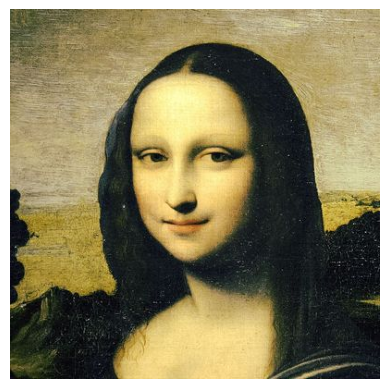

In [980]:
# image from link
url = "https://pyxis.nymag.com/v1/imgs/ccd/8a6/a1c2985ae120955603d45c82ebee96d8d3-29-Mona-Lisa.rsquare.w400.jpg"
# load image from this link
import urllib.request
from PIL import Image

image = Image.open(urllib.request.urlopen(url))

# tensor


# convert image to numpy array
image = np.array(image)
# crop and resize to 128x128
image = np.array(Image.fromarray(image).resize((400, 400)))

plt.imshow(image)
plt.axis('off')
plt.show()

## Retinal Compression

This might be best suited for in the dataloader as we only want this operation at the beginning of the retinal pathway. FOV of the phosphene simulator is typically set to 16. Look at config file and use variable.

In [981]:
import components.RetinalCompression as RetinalCompressionModule

ret = RetinalCompressionModule.RetinalCompression()

In [982]:
compressed = ret.single(image=image,   fov=16, out_size=128, inv=0, type=0, show=0, masking=1, series=0, masktype=1)
percept = ret.single(image=compressed, fov=16, out_size=128, inv=1, type=0, show=0, masking=1, series=0, masktype=1)

c:\Users\appel\Documents\Project\Dynaphos\viseon\components\RetinalCompression.py:271: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.minimum(np.maximum([math.floor(y_n[i]), math.ceil(y_n[i])], 0), self.inS - 1)
c:\Users\appel\Documents\Project\Dynaphos\viseon\components\RetinalCompression.py:272: ComplexWarning: Casting complex values to real discards the imaginary part
  y = np.minimum(np.maximum([math.floor(x_n[i]), math.ceil(x_n[i])], 0), self.inS - 1)


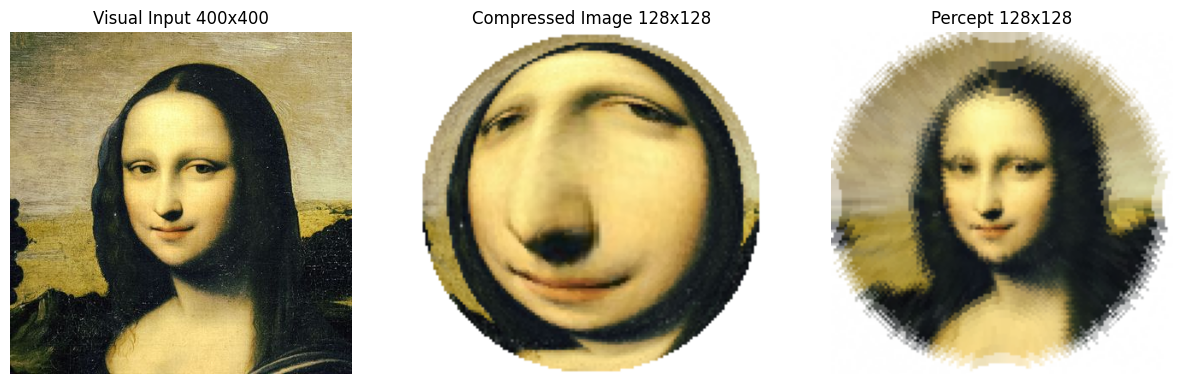

In [983]:
# Plot image, compressed image, and perceptual image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].axis('off')
# Size in title
ax[0].set_title('Visual Input ' + str(image.shape[0]) + 'x' + str(image.shape[1]))
ax[1].imshow(compressed)
ax[1].axis('off')
ax[1].set_title('Compressed Image ' + str(compressed.shape[0]) + 'x' + str(compressed.shape[1]))
ax[2].imshow(percept)
ax[2].axis('off')
ax[2].set_title('Percept ' + str(percept.shape[0]) + 'x' + str(percept.shape[1]))
plt.show()

Computational complexity of Retinal Compression is $O(N^2)$, where NN is the size of the grid (e.g., for a $256×256$ image, $N=256$).

# Difference of Gaussian

Difference of Gaussian implements a center-surround receptive field.

In [984]:
from components import DoG
importlib.reload(DoG)

from components.DoG import DoGConv2D

In [985]:
n_input = 3
n_output = 3
k_size = 3
stride = 1
padding = 1

img_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()

resize = 400
img_tensor = nn.functional.interpolate(img_tensor, size=(resize, resize), mode='bilinear', align_corners=False)

# Normal Conv2D
conv = nn.Conv2d(in_channels=n_input, out_channels=n_output, kernel_size=k_size, stride=stride, padding=padding)
# set weights to 1
conv.weight.data.fill_(1/(k_size*k_size*3))
conv.bias.data.fill_(0)
conv_out = conv(img_tensor)

# DoGConv2D
dog = DoGConv2D(in_channels=n_input, out_channels=n_output, k=k_size, stride=stride, padding=padding)
dog_out = dog(img_tensor)
dog_out = dog_out/dog_out.max()*255

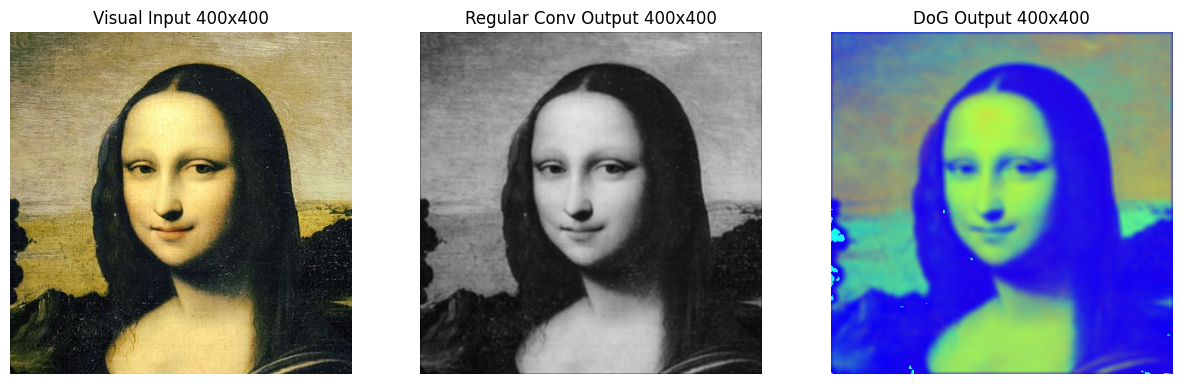

In [986]:
# Side by side resized_tensor, DoG output, and Conv output
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_tensor.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(img_tensor.shape[2]) + 'x' + str(img_tensor.shape[3]))

ax[1].imshow(conv_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Regular Conv Output ' + str(conv_out.shape[2]) + 'x' + str(conv_out.shape[3]))
                
ax[2].imshow(dog_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[2].axis('off')
ax[2].set_title('DoG Output ' + str(dog_out.shape[2]) + 'x' + str(dog_out.shape[3]))

plt.show()


In [987]:
# number of parameters in each layer
print('DoGConv2D Parameters:', sum(p.numel() for p in dog.parameters()))
print('Conv2D Parameters:', sum(p.numel() for p in conv.parameters()))

# Ratio
print('\nRatio:', sum(p.numel() for p in dog.parameters()) / sum(p.numel() for p in conv.parameters()))

DoGConv2D Parameters: 79
Conv2D Parameters: 84

Ratio: 0.9404761904761905


# Local Receptive fields

In [988]:
from components.LocallyConnected2d import LocallyConnected2d

In [989]:
n_input = 3
n_output = 3
output_size = 128
k_size = 3
stride = 1
padding = 1

resize = 128

# Resize to 64 x 64
resized_img = np.array(Image.fromarray(image).resize((resize, resize))) 
tensor_img = torch.tensor(resized_img).permute(2, 0, 1).unsqueeze(0).float() # shape torch.Size([1, 3, 64, 64])
tensor_img.requires_grad = True

# Fully Connected Layer
fullyConnected = nn.Linear(in_features=3*resize*resize, out_features=3*resize*resize)
# set all weights to 
fullyConnected.weight.data.fill_(1/(resize*resize*3))
fully_connected_out = fullyConnected(tensor_img.reshape(1, -1))

# Locally Connected Layer
locallyConnected2dlayer = LocallyConnected2d(in_channels=n_input, 
                                             out_channels=n_output, 
                                             output_size=output_size, 
                                             kernel_size=k_size, 
                                             stride=stride, 
                                             padding=padding)
locallyConnected2dlayer.weight.data.fill_(1/(k_size*k_size*3))
locally_connected_out = locallyConnected2dlayer(tensor_img)

# Select a specific neuron e.g. the middle one
neuron_position = (int(resize/2), int(resize/2))
neuron_activation = locally_connected_out[0, 0, neuron_position[0], neuron_position[1]]

# Backpropagate to the input image
locallyConnected2dlayer.zero_grad()
neuron_activation.backward(retain_graph=True)

# Get the gradient of the input image
gradient = tensor_img.grad

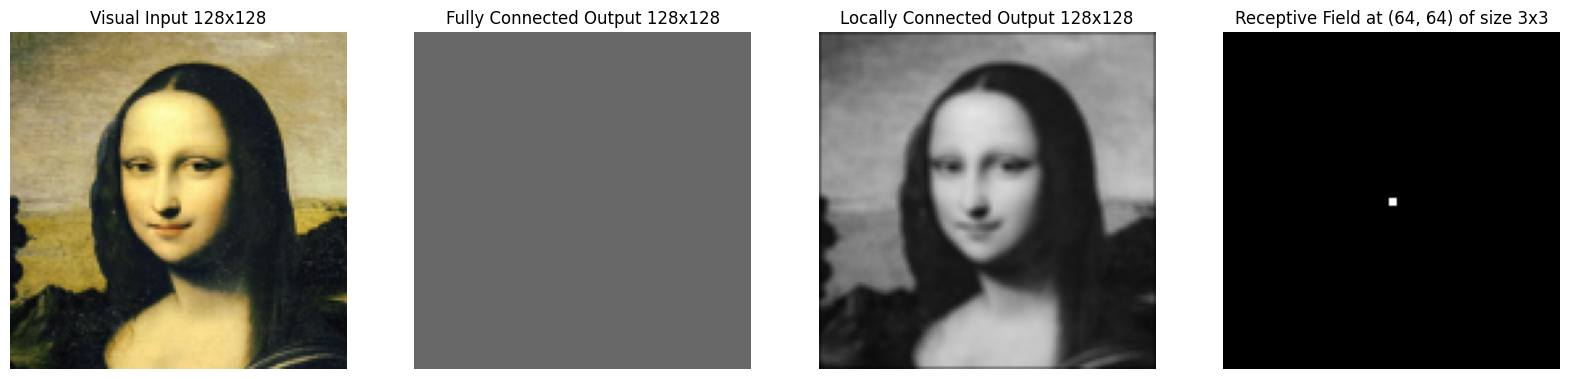

In [990]:
# Side by side input, Fully Connected output, Locally Connected output, and receptive field
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(resized_img)
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(resized_img.shape[0]) + 'x' + str(resized_img.shape[1]))

ax[1].imshow(fully_connected_out.detach().reshape(3, resize, resize).permute(1, 2, 0).numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Fully Connected Output ' + str(resize) + 'x' + str(resize))

ax[2].imshow(locally_connected_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[2].axis('off')
ax[2].set_title('Locally Connected Output ' + str(locally_connected_out.shape[2]) + 'x' + str(locally_connected_out.shape[3]))

ax[3].imshow(((gradient!=0)*255).squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[3].axis('off')
ax[3].set_title('Receptive Field at ' + str(neuron_position) + ' of size ' + str(k_size) + 'x' + str(k_size))
plt.show()

In [991]:
# number of parameters in each layer
print('LocallyConnected2d Parameters:', sum(p.numel() for p in locallyConnected2dlayer.parameters()))
print('FullyConnected Parameters:', sum(p.numel() for p in fullyConnected.parameters()))

# Ratio
print('\nRatio:', sum(p.numel() for p in locallyConnected2dlayer.parameters()) / sum(p.numel() for p in fullyConnected.parameters()))

LocallyConnected2d Parameters: 1327104
FullyConnected Parameters: 2415968256

Ratio: 0.0005493052306064736


# Divisive Normalization

In [992]:
from components import DivisiveNormalization
importlib.reload(DivisiveNormalization)

from components.DivisiveNormalization import DivisiveNormalizationCirincione, OpponentChannelInhibition

In [993]:
tensor_img = torch.tensor(np.array(Image.fromarray(image))).permute(2, 0, 1).unsqueeze(0).float()

In [994]:
divisize_norm = DivisiveNormalizationCirincione(channels=3, gaussian_kernel_size=3)
divisive_norm_out = divisize_norm(tensor_img)
divisive_norm_out = divisive_norm_out/divisive_norm_out.max()*255

opponent_channel_inhibition = OpponentChannelInhibition(n_channels=3)
opponent_channel_inhibition_out = opponent_channel_inhibition(tensor_img)
opponent_channel_inhibition_out = opponent_channel_inhibition_out/opponent_channel_inhibition_out.max()*255

# Normal normalization
norm = nn.LocalResponseNorm(size=3, alpha=1e-4, beta=0.75, k=1)
norm_out = norm(tensor_img)
# norm_out = norm_out/norm_out.max()*255

# Batch Normalization
batch_norm = nn.BatchNorm2d(3)
batch_norm_out = batch_norm(tensor_img)
# batch_norm_out = batch_norm_out/batch_norm_out.max()*255


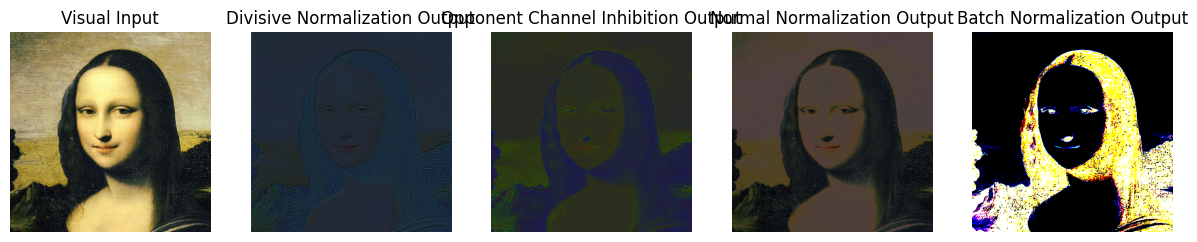

In [995]:
# Show the input image, Divisive Normalization output, and Opponent Channel Inhibition output
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(tensor_img.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[0].axis('off')
ax[0].set_title('Visual Input')

ax[1].imshow(divisive_norm_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Divisive Normalization Output')

ax[2].imshow(opponent_channel_inhibition_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[2].axis('off')
ax[2].set_title('Opponent Channel Inhibition Output')

ax[3].imshow(norm_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[3].axis('off')
ax[3].set_title('Normal Normalization Output')

ax[4].imshow(batch_norm_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[4].axis('off')
ax[4].set_title('Batch Normalization Output')

plt.show()

In [996]:
# number of parameters in each layer
print('DivisiveNormalizationCirincione Parameters:', sum(p.numel() for p in divisize_norm.parameters()))
print('OpponentChannelInhibition Parameters:', sum(p.numel() for p in opponent_channel_inhibition.parameters()))
print('LocalResponseNorm Parameters:', sum(p.numel() for p in norm.parameters()))
print('BatchNorm2d Parameters:', sum(p.numel() for p in batch_norm.parameters()))

DivisiveNormalizationCirincione Parameters: 55
OpponentChannelInhibition Parameters: 12
LocalResponseNorm Parameters: 0
BatchNorm2d Parameters: 6


# Polar Transform
For cortical magnification

In [997]:
from components import PolarTransform
importlib.reload(PolarTransform)

from components.PolarTransform import PolarTransform

In [998]:
resize = 128
resized_img = np.array(Image.fromarray(image).resize((resize, resize))) 
tensor_img = torch.tensor(resized_img).permute(2, 0, 1).unsqueeze(0).float()

In [999]:
img_size = tensor_img.shape[2]
out_size = 64
input_h, input_w = img_size, img_size
output_h, output_w = out_size, out_size
interpolation = 'linear'
subbatch_size = 1

foveal_radius = 48  # Increasing the foveal radius
foveal_dists = np.arange(foveal_radius)
periphery_dists = [48, 50, 54, 60, 66, 76, 88, 100, 112, 124]
radius_bins = list(foveal_dists) + list(periphery_dists)
angle_bins = list(np.linspace(0, 2*np.pi, img_size+1-2))

polar_transform = PolarTransform(
                                input_h=input_h,
                                input_w=input_w,
                                output_h=output_h,
                                output_w=output_w,
                                radius_bins=radius_bins,
                                angle_bins=angle_bins,
                                interpolation=interpolation,
                                subbatch_size=subbatch_size)

In [1000]:
polar_transform_out = polar_transform(tensor_img)

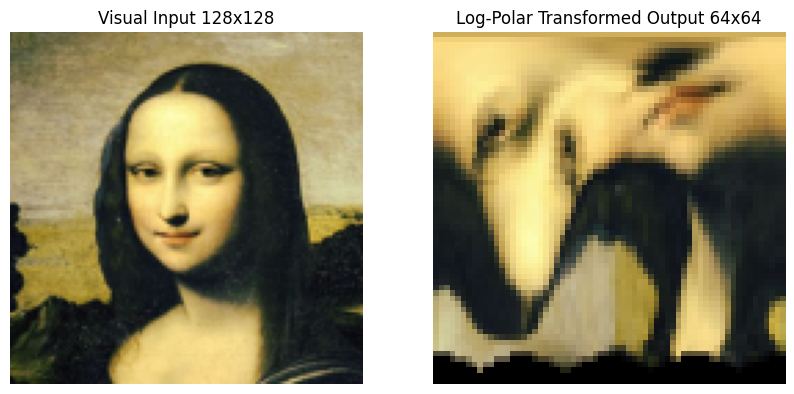

In [1001]:
# Visualize the input image and the polar transformed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(resized_img)
ax[0].axis('off')
ax[0].set_title('Visual Input ' + str(resized_img.shape[0]) + 'x' + str(resized_img.shape[1]))

ax[1].imshow(polar_transform_out.squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8))
ax[1].axis('off')
ax[1].set_title('Log-Polar Transformed Output ' + str(polar_transform_out.shape[2]) + 'x' + str(polar_transform_out.shape[3]))

plt.show()


In [1007]:
def polar_transform_complexity(batch_size, channels, input_h, input_w, radius_bins, angle_bins, output_h, output_w):
    R = len(radius_bins) - 1
    A = len(angle_bins) - 1
    
    masking_operations = batch_size * channels * input_h * input_w * R * A
    summing_operations = batch_size * channels * R * A
    resizing_operations = batch_size * channels * output_h * output_w * 4
    
    total_operations = masking_operations + summing_operations + resizing_operations
    return total_operations

# Complexity of the Polar Transform
print('Polar Transform Complexity:', polar_transform_complexity(1, 3, 128, 128, radius_bins, angle_bins, 64, 64))

Polar Transform Complexity: 353080362
